# Inżynieria lingwistyczna
Ten notebook jest oceniany półautomatycznie. Nie twórz ani nie usuwaj komórek - struktura notebooka musi zostać zachowana. Odpowiedź wypełnij tam gdzie jest na to wskazane miejsce - odpowiedzi w innych miejscach nie będą sprawdzane (nie są widoczne dla sprawdzającego w systemie).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE".

---

# Zadanie 1 - tokenizacja (12 pkt)

Jedną z nowoczesnych technik tokenizacji jest BPE - byte-pair encoding [1]. Technika ta polega na podzielenie słów na częste podsłowa (a'la morfemy?). W przeciwieństwie do podejść lingwistycznych, wymagających zwykle ręcznie napisanych reguł tworzenia morfemów czy nawet słowników lematów, BPE znajduje je heurystycznie poprzez wyznaczenie najczęstszych przylegających do siebie sekwencji znaków.

Algorytm przebiega w następujących krokach.
1. Podziel wszystkie słowa na symbole (początkowo pojedyncze znaki)
2. Wyznacz najczęściej występującą obok siebie parę symboli 
3. Stwórz nowy symbol będący konkatenacją dwóch najczęstszych symboli.

Uwaga 1: każde słowo zakończone jest specjalnym symbolem końca wyrazu.

Uwaga 2: tworzenie nowego symbolu nie powoduje usuniecie starego tj. zawsze jednym z możliwych symboli jest pojedynczy znak, ale jeśli można to stosujemy symbol dłuższy.

Przykład: korpus w którym występuje ,,ala'' 5 razy i ,,mama 10 razy''
1. Dzielimy słowa na symbole ,,a l a END'' ,,m a m a END''  gdzie END jest symbolem końca wyrazu.
2. Najczęstsza para obok siebie to ,,m a'' (20 razy)
3. Nowy symbol ,,ma''
4. Nowy podział ,,a l a END'' ,,ma ma END''
5. Najczęstsza para ,,ma ma'' (10 razy)
6. Nowy symbol ,,mama''
7. Nowy podział ,,a l a END'' ,,mama END''
8. itd.

W pliku ,,brown_clusters.tsv'' pierwsza kolumna to identyfikator skupienia (nie używamy w tym zadaniu), druga kolumna to wyrazy, a trzecia to ich liczności w pewnym korpusie tweetów. Zaimplementuj technikę BPE i przetesuj ją na tych słowach.

Parametrem algorytmu BPE jest `number_of_iterations` czyli liczba iteracji (łączeń symboli). Dodatkowo implementacja powinna mieć parametr `verbose`, którego wartość `True` powinna skutkować wypisywaniem na konsolę wykonywanych operacji (tj. łączeń).

[1] Sennrich, R., Haddow, B., and Birch, A. (2016). Neural machine translation of rare words with subword units. In ACL 2016.

In [23]:
import pandas as pd
import numpy as np
import string
from tqdm import tqdm
from collections import defaultdict 

brown_df = pd.read_csv('brown_clusters.tsv', sep='\t', header=0, names=['cluster', 'word', 'count'])
number_of_iterations = 10

def join_tuples(df, tup):
     for _, row in df.iterrows():
            count_join = 0
            for index in range(len(row["word"]) - 1):
                if index + count_join > len(row["word"]) - 1:
                    break
                temp_tuple = row["word"][index] + row["word"][index + 1]
                if temp_tuple == tup:
                    row["word"][index] = tup
                    del row["word"][index + 1]
                    count_join += 1
     return df

def preform_bpe(brown_df, number_of_iterations, verbose = False):
    """
    Funckcja przyjmuje ramkę w formacie analogicznym do obiektu brown_df (wczytany wyżej)
     oraz liczbę iteracji.
    Wyjściem funkcji powinna być lista słów z poszczególnymi tokenami/symbolami oddzielonymi spacją.
    Za znak końca wyrazu przyjmij END. 
    """
    # alph = [*string.ascii_lowercase, "END"]
    df = brown_df.drop(columns=["cluster"])
    df["word"] = df["word"].apply(lambda x: [*str(x), "END"])

    for _ in tqdm(range(number_of_iterations)):
        max_join = ""
        count_dict = defaultdict(lambda: 0)


        for _, row in df.iterrows():
            for index in range(len(row["word"]) - 1):
                join = row["word"][index] + row["word"][index + 1]
                count_dict[join] += row["count"]

        max_join = max(count_dict, key=count_dict.get)
        count_dict[max_join] = 0
        df = join_tuples(df, max_join)
        if(verbose):
            print(f"join: {max_join}")
    
    return df["word"].apply(lambda x: " ".join(x)).tolist()

Test implementacji:

In [67]:
from nose.tools import assert_list_equal
data = {'cluster': range(2), 'word':['ala', 'mama'], 'count': [5,10]}
df = pd.DataFrame (data, columns = ['cluster', 'word', 'count'])
vocab = preform_bpe(df, 1)
assert_list_equal(vocab, ['a l a END', 'ma ma END'])

100%|██████████| 1/1 [00:00<00:00, 967.32it/s]


Spraw aby Twoja implementacja wypisywała kolejne łączone ze sobą symbole (parametr `verbose`) i uruchom Twoją funkcję na np. 50 iteracji, obserwując jakie tokeny są tworzone.

In [68]:
preform_bpe(brown_df, 50, verbose=True)

  2%|▏         | 1/50 [00:35<28:36, 35.02s/it]

join: eEND


  4%|▍         | 2/50 [01:08<27:30, 34.39s/it]

join: tEND


  6%|▌         | 3/50 [01:42<26:30, 33.84s/it]

join: sEND


  8%|▊         | 4/50 [02:14<25:37, 33.43s/it]

join: in


 10%|█         | 5/50 [02:47<24:47, 33.05s/it]

join: th


 12%|█▏        | 6/50 [03:19<24:06, 32.88s/it]

join: dEND


 14%|█▍        | 7/50 [03:52<23:28, 32.75s/it]

join: yEND


 16%|█▌        | 8/50 [04:24<22:46, 32.53s/it]

join: .END


 18%|█▊        | 9/50 [04:56<22:07, 32.38s/it]

join: oEND


 20%|██        | 10/50 [05:28<21:29, 32.25s/it]

join: rEND


 22%|██▏       | 11/50 [06:00<20:53, 32.15s/it]

join: an


 24%|██▍       | 12/50 [06:32<20:20, 32.12s/it]

join: >END


 26%|██▌       | 13/50 [07:04<19:51, 32.19s/it]

join: on


 28%|██▊       | 14/50 [07:36<19:18, 32.18s/it]

join: ou


 30%|███       | 15/50 [08:08<18:41, 32.05s/it]

join: gEND


 32%|███▏      | 16/50 [08:40<18:06, 31.97s/it]

join: aEND


 34%|███▍      | 17/50 [09:11<17:30, 31.84s/it]

join: lEND


 36%|███▌      | 18/50 [09:43<16:56, 31.78s/it]

join: ingEND


 38%|███▊      | 19/50 [10:14<16:19, 31.58s/it]

join: <@


 40%|████      | 20/50 [17:43<1:18:23, 156.79s/it]

join: <@M


 42%|████▏     | 21/50 [20:03<1:13:21, 151.78s/it]

join: <@ME


 44%|████▍     | 22/50 [22:29<1:09:59, 149.99s/it]

join: <@MEN


 46%|████▌     | 23/50 [24:55<1:06:55, 148.73s/it]

join: <@MENT


 48%|████▊     | 24/50 [27:22<1:04:16, 148.33s/it]

join: <@MENTI


 50%|█████     | 25/50 [29:46<1:01:13, 146.92s/it]

join: <@MENTIO


 52%|█████▏    | 26/50 [32:04<57:44, 144.37s/it]  

join: <@MENTION


 54%|█████▍    | 27/50 [34:25<55:00, 143.50s/it]

join: <@MENTION>END


 56%|█████▌    | 28/50 [36:49<52:39, 143.63s/it]

join: re


 58%|█████▊    | 29/50 [39:12<50:11, 143.38s/it]

join: iEND


 60%|██████    | 30/50 [41:35<47:42, 143.10s/it]

join: theEND


 62%|██████▏   | 31/50 [43:57<45:14, 142.87s/it]

join: en


 64%|██████▍   | 32/50 [46:19<42:47, 142.63s/it]

join: om


 66%|██████▌   | 33/50 [48:38<40:07, 141.63s/it]

join: toEND


 68%|██████▊   | 34/50 [51:00<37:45, 141.60s/it]

join: ,END


 70%|███████   | 35/50 [53:22<35:24, 141.64s/it]

join: !END


 72%|███████▏  | 36/50 [55:43<33:03, 141.66s/it]

join: er


 74%|███████▍  | 37/50 [58:04<30:37, 141.37s/it]

join: ha


 76%|███████▌  | 38/50 [1:00:24<28:10, 140.89s/it]

join: erEND


 78%|███████▊  | 39/50 [1:02:44<25:46, 140.56s/it]

join: it


 80%|████████  | 40/50 [1:05:03<23:22, 140.28s/it]

join: :END


 82%|████████▏ | 41/50 [1:07:23<21:01, 140.15s/it]

join: you


 84%|████████▍ | 42/50 [1:09:43<18:41, 140.23s/it]

join: ar


 86%|████████▌ | 43/50 [1:12:02<16:17, 139.70s/it]

join: al


 88%|████████▊ | 44/50 [1:14:20<13:55, 139.25s/it]

join: or


 90%|█████████ | 45/50 [1:16:32<11:25, 137.12s/it]

join: ow


 92%|█████████▏| 46/50 [1:17:10<07:08, 107.17s/it]

join: ..END


 94%|█████████▍| 47/50 [1:17:43<04:14, 84.92s/it] 

join: st


 96%|█████████▌| 48/50 [1:18:15<02:18, 69.07s/it]

join: kEND


 98%|█████████▊| 49/50 [1:18:48<00:58, 58.33s/it]

join: isEND


100%|██████████| 50/50 [1:19:20<00:00, 95.22s/it]

join: fEND


['\\ iEND',
 '/ i / END',
 't o d a y - iEND',
 'n ow iEND',
 '# you e v erEND',
 'i f in al l yEND',
 '「 iEND',
 '- i - END',
 'in e v aEND',
 '» iEND',
 'w ha t t a y aEND',
 'i i i i i i i i i iEND',
 '\ue6d1 END',
 'i k in d aEND',
 'l o l - iEND',
 'i a c t u al l yEND',
 'w a d d y aEND',
 '# a s l on g a s you END',
 'd o you END',
 '\u200e \u200b iEND',
 'i ̇ END',
 'ï END',
 '# l o l a t g i r l s w h oEND',
 '# r t i f you END',
 'i j s tEND',
 '« iEND',
 '• iEND',
 'w h o d aEND',
 'w ha d y aEND',
 ') iEND',
 '+ iEND',
 '# you r f a c e m a k e s m eEND',
 'i i i i i i i iEND',
 '` iEND',
 'i i i i i i iEND',
 'i al re a d yEND',
 '_ iEND',
 '# you m a k e m eEND',
 '* iEND',
 '| iEND',
 '# u r b o y f r i en d e v erEND',
 'w h en iEND',
 'ι END',
 "d on ' t c h aEND",
 "w h o ' d aEND",
 'd you END',
 'w ha d d a y aEND',
 'i on l yEND',
 'i j u s sEND',
 'i al w a y sEND',
 'i i i i iEND',
 'd on c h aEND',
 '( iEND',
 "d ' y aEND",
 'ı END',
 '# u e v erEND',
 'in e v e

- Jakie angielskie słowo jako pierwsze dostało swój własny token?

Jako czwarte zostało połączone angielskie słowo: `in`

- Jakie są zalety korzystania z tokenizacji BPE w kontekście tworzenia reprezentacji do problemu klasyfikacji tekstu (problem OOV, odnieś się do k-gramów i n-gramów)? Jakie są zalety BPE w przypadku przetwarzania różny rodzajów języków (np. fleksyjne, aglutynacyjne)?

Niewątpliwą zaletą tokenizacji BPE jest rozwiązanie problemu OOV. Algorytm tworząc słownik połączonych ze sobą części wyrazów, w prosty sposób jest w stanie podzielić nieznany mu wyraz na mniejsze, znane już mu zbiory liter. Inną zaletą jest również łatwa możliwość dostosowania algorytmu do k-gramów i n-gramów, co może wpłynąć na wynik poprzez to, że uwzględniany będzie szerszy kontekst. BPE jest również skuteczny w językach fleksyjnych i aglutynacyjnych. Sposób działania algorytmu powoduje oddzielanie się od siebie morfemów, a więc `główna_część_wyrazu - affiks` również będą oddzielone ze względu na to jak często będą występowały w korpusie.

Wróć do implementacji i zakomentuj wypisywanie (funkcje print) informacji z funkcji `preform_bpe`.

# Zadanie 2 - klasyfikacja (15 pkt)

Poniższy kod powinien wczytać i ztokenizować zbiór danych dot. analizy wydźwięku. Jeśli nie masz biblioteki `nltk` musisz ją zainstalować.

In [24]:
from helpers import DataSet
training_set = DataSet(['tweets.txt'])

Reading data set ['tweets.txt']


Poniżej znajdziesz przykład odczytu jednego tweeta z obiektu DataSet

In [ ]:
for i in training_set.tweets:
    print(i.text)
    print(i.tokens)
    print(i.clazz)
    break

Systemy IL często pracują z bardzo dużą liczbą cech, które są rzadkie np. cechy Bag-Of-Words, cechy n-gramowe itd. Powoduje to że klasyczna macierz zawierająca przykłady uczące ($n$) i cechy ($d$) rośnie do bardzo dużych rozmiarów ($nd$) nawet dla małych zbiorów uczących (w sensie liczby przykładów). Ponadto samo przechowywanie w pamięci słownika mapującego konkretne słowa/n-gramy na indeksy kolumn macierzy może być bardzo kosztowne pamięciowo przy dużych rozmiarach słownika.

Istnieje jednak technika, która pozwala nam na ominięcie tej przeszkody: haszowanie cech. Opis tej techniki znajdziesz na stronie:  https://en.wikipedia.org/wiki/Feature_hashing Jest ona też implementowana w obiekcie `sklearn.feature_extraction.FeatureHasher`. Zapoznaj się z opisem techniki i wykonaj poniższe polecenia.

- Wykorzystując haszowanie cech wytrenuj wybrany klasyfikator (najlepiej taki, który się szybko liczy) na zbiorze uczącym dla cech Bag-of-words (możesz też spróbować cechy n-gramowe). Możesz wykorzystać gotową tokenizację we właściwości `.tokens`.

In [25]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import FeatureHasher

unique = set(list(np.concatenate([tweet.tokens for tweet in training_set.tweets]).flat))

hasher = FeatureHasher(n_features=len(unique), input_type="string")

X = [tweet.tokens for tweet in training_set.tweets]
y = [tweet.clazz for tweet in training_set.tweets]

X_train, X_test, y_train, y_test = train_test_split(hasher.transform(X), y, test_size=0.2)

clf = DecisionTreeClassifier(max_depth=5, random_state=60)

clf.fit(X_train, y_train).score(X_test, y_test)

0.5595238095238095

- Stwórz wykres zależności wybranej miary klasyfikacji od wymiarów macierzy danych (chodzi o liczbę cech do których haszujemy cechy oryginalne). Wystarczy przetestować kilka (>=4) wybranych wartości na skali logarytmicznej.

  0%|          | 0/6 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:00<00:00,  6.62it/s]


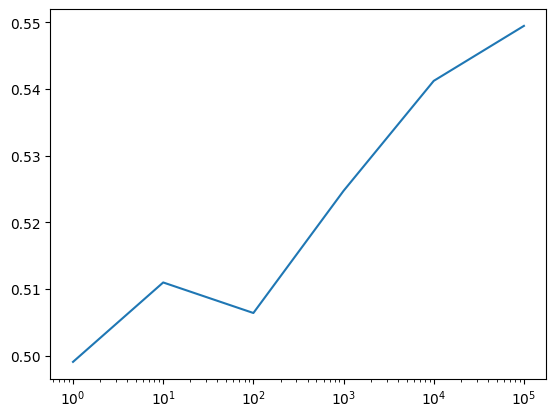

In [27]:
import matplotlib.pyplot as plt
from tqdm import tqdm

sizes = [10 ** x for x in range(0,6)]

X = [tweet.tokens for tweet in training_set.tweets]
y = [tweet.clazz for tweet in training_set.tweets]

acc = []
clf = DecisionTreeClassifier(max_depth=5, random_state = 60)

for n_size in tqdm(sizes):
    hasher = FeatureHasher(n_features=n_size, input_type="string")
    X_train, X_test, y_train, y_test = train_test_split(hasher.transform(X), y, test_size=0.2)

    acc.append(clf.fit(X_train, y_train).score(X_test, y_test))

plt.plot(sizes, acc)
plt.xscale("log")
plt.show()



 - Obserwując stworzony wykres - skomentuj. Jak dużo jakości klasyfikacji się traci (albo zyskuje?) korzystając z mniejszej liczby haszowanych cech? Często klasyfikatory bardzo dobrze działają nawet przy liczbie haszowanych cech dla których na pewno istnieją konflikty cech oryginalnych - jak myślisz dlaczego? (Pomyśl o interpretacji takich skonfliktowanych cech).

Korzystając z klasyfikatora `DecisionTreeClassifier` jakość rośnie w miarę zwiększania liczby cech. Miara `accuracy` z początkowych 0.50 wzrasta do 0.55. Ponadto największy wzrost zauważalny jest pomiędzy 10^2, a 10^4 liczby cech. Jeszcze większa liczba cech nie dostarcza już takiej szybkiej poprawy jakości.

W przypadku konfliktów, funkcja hashująca może przydzielić podobnym znaczeniowo wyrazom takie same wartości. To działa zdecydowanie korzystanie dla algorytmu, który przez to osiąga lepsze wyniki.

 - W poprzednim zadaniu wczytałeś wynik grupowania Browna do pamięci. Wytrenuj klasyfikator na reprezentacji ,,Bag-of-clusters'' tj. w kolumnach zamiast słów/n-gramów będziesz miał grupy.

In [37]:
clusters = list(set([cluster for cluster in brown_df.cluster]))
word_clusters = {word: cluster for word, cluster in zip(brown_df.word, brown_df.cluster)}

X = []
y = [tweet.clazz for tweet in training_set.tweets]
clf = DecisionTreeClassifier(max_depth=5, random_state = 60)
for tweet in training_set.tweets:
    code = [0] * len(clusters)
    for word in tweet.tokens:
        if word in word_clusters.keys():
            code[clusters.index(word_clusters[word])] = 1
        
    X.append(code)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=60)
print(clf.fit(X_train, y_train).score(X_test, y_test))

0.5686813186813187


- Podsumuj eksperymenty: poznałeś dwie możliwości ograniczenia liczby cech - zastąpienie słów ich grupami i haszowanie cech. Jakie są wady i zalety obydwu podejść?

Obie reprezentacje osiągnęły podobny wynik: 0.55/0.56. W obu wariantach zastosowany został również klasyfikator `DecisionTree` o głębokości drzewa równej 5. Natomiast biorąc pod uwagę ilość cech (koło 1000 cech) to podejście Bag of Clusters ma trochę większą przewagę (0.52 do 0.56). Nadal jednak są to dosyć małe różnice.

Główną zaletą Hashowania cech jest skuteczne radzenie sobie ze słowami spoza słownika, czego już nie można powiedzieć o podejściu Bag-of-clusters. Wadą hashowania są natomiast kolizje (które czasami mogą prowadzić do pogorszenia jakości klasyfikacji). Bag-of-clusters natomiast posiada naturalną przewagę poprzez to, że bazuje na istniejących już grupach, które łączą ze sobą podobne semantycznie wyrazy.